In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [30]:
import datajoint as dj
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os, cv2
import pandas as pd
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind

def range_scaler(img, low, high):
    """
    
    Minmax scale using a given range, then put mean to 127 (i.e. mid value for 8 bit image)
    Note, this scaling does not guarantee [0,255]. You need further post processing if one desires to
    use this for stimulus.
    
    Input:
        img(nd array): numpy array in order of (h x w x c)
        low: low bound for min-max scale
        high: high bound for min-max scale
    
    Return:
        img(nd array): numpy array image in order of (h x w x c) in float
    """

    template = np.zeros(img.shape)
    _range = high - low

    for ind, img_channel in enumerate(img.transpose(2,0,1)):

        #shrink pixel values between low and high by min-maxing
        normalized_img = (img_channel - img_channel.min())/(img_channel.max()- img_channel.min()) * _range + low

        #find difference between the current mean and 127, and offset by that value
        difference = 127.0 - normalized_img.mean()
        
        normalized_img += difference
        
        template[:,:,ind] = normalized_img
        
    return template


def elu(z, alpha = -1):
    return z if z >= 0 else alpha*(e^z -1)

def obtain_stats_mean_subtracted_for_mean(images, outliers=[]):
    stats = dict(blue_mean =[], green_mean= [], blue_std=[], green_std=[])
    
    for ind, img in enumerate(images):
        if ind in outliers:
            # outlier detected, pass
            continue
        stats['green_mean'].append(abs(img[:,:,0].mean()-127))
        stats['blue_mean'].append(abs(img[:,:,1].mean()-127))

        stats['green_std'].append(img[:,:,0].std())
        stats['blue_std'].append(img[:,:,1].std())
    
    return stats

def obtain_stats_rgb(images, outliers=[]):
    stats = dict(blue_mean =[], green_mean= [], blue_std=[], green_std=[], blue_range=[], green_range=[])
    
    for ind, img in enumerate(images):
        if ind in outliers:
            # outlier detected, pass
            continue
        stats['green_mean'].append(img[:,:,1].mean())
        stats['blue_mean'].append(img[:,:,2].mean())

        stats['green_std'].append(img[:,:,1].std())
        stats['blue_std'].append(img[:,:,2].std())
        
        stats['green_range'].append(img[:,:,1].max() - img[:,:,1].min())
        stats['blue_range'].append(img[:,:,2].max() - img[:,:,2].min())
        
    return stats



def obtain_stats(images, outliers=[]):
    stats = dict(blue_mean =[], green_mean= [], blue_std=[], green_std=[])
    
    for ind, img in enumerate(images):
        if ind in outliers:
            # outlier detected, pass
            continue
        stats['green_mean'].append(img[:,:,0].mean())
        stats['blue_mean'].append(img[:,:,1].mean())

        stats['green_std'].append(img[:,:,0].std())
        stats['blue_std'].append(img[:,:,1].std())
    
    return stats

def add_noise(img, var, mean=127):
    
    row, col, ch = img.shape
    sigma = var**0.5
    gauss_noise = np.random.normal(mean, sigma, (row,col,1))
    gauss_noise = np.repeat(gauss_noise, ch, axis=2)

    return img + gauss_noise

In [3]:
stimulus = dj.create_virtual_module('stimulus','pipeline_stimulus')
imagenet = dj.create_virtual_module('imagenet','pipeline_imagenet')

Connecting donnie@10.28.0.34:3306


In [4]:
from neuro_data.ColorMEI_pilot.fake_signal_generation import GaborKernels

In [5]:
# float_key = dict(original_file_name = 'Gabors.h5')
uint8_key = dict(original_file_name = 'uint8_gabors.h5')

In [6]:
# float_kernels = (GaborKernels & float_key).fetch1('kernels').transpose(3,2,1,0)
int_kernels = (GaborKernels & uint8_key).fetch1('kernels').transpose(3,2,1,0)

In [7]:
gabor_biased = h5py.File('Gabors_Biased.h5')
green = gabor_biased['Gabors_Green'][:]
uv = gabor_biased['Gabors_UV'][:]
biased_kernels= np.stack((green, uv)).transpose(3,2,1,0)

In [8]:
image_cases = ['biased_correlated', 'biased_uncorrelated', 'unbiased_correlated', 'unbiased_uncorrelated']
classes = ['imagenet_v2_rgb',
           'imagenet_v2_rgb_g_b_no_normalization',
           'imagenet_v2_rgb_range_30_225_mean127',
           'imagenet_v2_rgb_g_b_channels_separately_joined']

img_dict = dict()

for case, _class in zip(image_cases, classes):
    img_dict[case] = dict(img_class= _class, img= None)


In [9]:
for _key, _val in img_dict.items():
    
    if _key == 'unbiased_correlated' or _key == 'unbiased_uncorrelated':
        # this works for now cuz there is only 1 album. later we might need more restriction
        img_dict[_key]['img'] = (stimulus.StaticImage.Image & 'image_class = "{}"'.format(img_dict[_key]['img_class'])).fetch('image')
    
    elif _key == 'biased_correlated':
        img_ids =(stimulus.StaticImage.Image & 'image_class = "imagenet_v2_rgb_range_30_225_mean127"').fetch('image_id')
        temp = []
        for _id in img_ids:
            img = (stimulus.StaticImage.Image & 'image_class = "imagenet_v2_rgb" and image_id = {}'.format(_id)).fetch1('image')
            temp.append(img)
        
        img_dict[_key]['img'] = temp
    elif _key == 'biased_uncorrelated':
        single_album = imagenet.Album.Single & 'image_class = "imagenet_v2_rgb_g_b_channels_separately_joined"'
        oracle_album = imagenet.Album.Oracle & 'image_class = "imagenet_v2_rgb_g_b_channels_separately_joined"'

        img_id_1, img_id_2 = (imagenet.TwoImagesCombo() & (single_album + oracle_album).proj(combined_id='image_id',new_image_class = "image_class")).fetch('image_id_1','image_id_2', order_by="image_id_1 ASC")
        
        temp = []
        for id_g, id_b in zip(img_id_1, img_id_2):
                        
            img_g = (stimulus.StaticImage.Image & 'image_class = "imagenet_v2_rgb" and image_id = {}'.format(id_g)).fetch1('image')
            img_b = (stimulus.StaticImage.Image & 'image_class = "imagenet_v2_rgb" and image_id = {}'.format(id_b)).fetch1('image')

            img = np.zeros(img_g.shape, dtype=np.uint8)
            
            img[:,:,1] = img_g[:,:,1]
            img[:,:,2] = img_b[:,:,2]
            
            temp.append(img)
            
        img_dict[_key]['img'] = temp

# When doing STAs, do it only on Train dataset

In [ ]:
# # generate oracle trials 
# for _key, _val in img_dict.items():
#     stacked_images = np.stack(img_dict[_key]['img'])
#     oracles = np.repeat(stacked_images[5000:],10, axis=0)
#     img_dict[_key]['img'] = np.vstack((stacked_images[:5000], oracles))
    
    

In [12]:
# generate oracle trials 
for _key, _val in img_dict.items():
    img_dict[_key]['img'] = np.stack(img_dict[_key]['img'][:4950]) 

center gabor around 127 by substracting mean, same for the images, 
subtract minimum from each response block to only have positive values, 
normalize responses to range between 0 and 100 (as these values make sense with regard to firing rate), 
pass through non linearity (50th percentile), transform response to each image using poisson process

In [14]:
def generate_response_block(img_case, orig_kernels):
    
    kernels = []
    
    for kernel in orig_kernels:
        # subtract mean from both channels
        kernels.append(kernel - kernel.mean(0).mean(0))
        
    kernels = np.stack(kernels)
    
    images = np.stack(img_dict[img_case]['img'])
#     images = np.stack(img_dict[img_case]['img'][:3])
    
    response_block = np.zeros((len(images), len(kernels)))
    # multiply images with kernels
    for img_ind, img in enumerate(images):
        img = cv2.resize(img, (64,36), interpolation=cv2.INTER_AREA).astype(np.float64)[:,:,1:]
        # subtract mean from both channels
        img -= img.mean(0).mean(0)
        
        if not img_ind%100:
            print(img_ind)
        convolved = np.multiply(img, kernels)

        # introduce nonlinearity
#         convolved[convolved<0] = 0 

        signals = convolved.reshape(len(kernels),-1).sum(-1)

        response_block[img_ind,:] = signals
    return response_block

In [15]:
for img_case in image_cases:
    response_block = generate_response_block(img_case, orig_kernels=int_kernels)
    img_dict[img_case]['response_block'] = response_block

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [16]:
# subtract min from each kernel response block
for img_case in image_cases:
    # initialize
    img_dict[img_case]['response_block_min_subtracted'] = np.zeros(img_dict[img_case]['response_block'].shape)
    
    for ind, kernel_response in enumerate(img_dict[img_case]['response_block'].T):
        img_dict[img_case]['response_block_min_subtracted'][:,ind] = kernel_response - kernel_response.min()

In [17]:
# normalize the response between 0 and 100
for img_case in image_cases:
    # initialize
    img_dict[img_case]['response_block_normalized'] = np.zeros(img_dict[img_case]['response_block_min_subtracted'].shape)
    
    for ind, kernel_response in enumerate(img_dict[img_case]['response_block_min_subtracted'].T):
        
        normalized = (kernel_response - kernel_response.min())/(kernel_response.max() - kernel_response.min()) * 100
        
        img_dict[img_case]['response_block_normalized'][:,ind] = normalized

In [18]:
#poisson transformation
for img_case in image_cases:
    # initialize
    img_dict[img_case]['response_block_poisson'] = np.zeros(img_dict[img_case]['response_block_normalized'].shape)
  
    for ind, kernel_response in enumerate(img_dict[img_case]['response_block_normalized'].T):

        img_dict[img_case]['response_block_poisson'][:,ind] = np.random.poisson(kernel_response)


In [104]:
# tier = []
# for i in range(4950):
#     tiers.append(str.encode("train"))
# for i in range(4950,5000):
#     tiers.append(str.encode("validation"))
# for i in range(5000,6000):
#     tiers.append(str.encode("test"))
# tier = np.array(tier)

In [106]:
# for key in img_dict.keys():
    
#     with h5py.File(key + '_gabor_poisson.h5', "w") as fh:
        
#         img_tmp = []
#         images = img_dict[key]['img']
        
#         for img_ind, img in enumerate(images):
#             img = cv2.resize(img, (64,36), interpolation=cv2.INTER_AREA).astype(np.float32)[:,:,1:]
#             img_tmp.append(img)
        
        
#         fh.create_dataset('images', data=np.stack(img_tmp).transpose(0,3,1,2))
#         fh.create_dataset('true_rate', data=img_dict[key]['response_block_normalized'].astype(np.float32))
#         fh.create_dataset('responses', data=img_dict[key]['response_block_poisson'].astype(np.float32))
#         fh.create_dataset('behavior', data=np.zeros((len(img_tmp),3), dtype=np.float32))
#         fh.create_dataset('pupil_center', data=np.zeros((len(img_tmp),3), dtype=np.float32))
#         fh.create_dataset('tiers', data=tiers)

In [19]:
def sta_generation_full(img_case, percentile=50, response_case = 'response_block_poisson'): 
    
    response_block = img_dict[img_case][response_case]

    tmp_images = np.stack(img_dict[img_case]['img'])[:,:,:,1:]
    images = []
    
    for ind, img in enumerate(tmp_images):
        images.append(cv2.resize(img, (64,36), interpolation=cv2.INTER_AREA).astype(np.uint8))
    images = np.stack(images)
    #Note when generating STAs, we do not subtract the mean
    
    sta_rf = np.zeros(shape=(response_block.shape[-1],*images.shape[1:]))

    
    for ind, response in enumerate(response_block.T):
        if ind%100 == 0:
            print(ind)
        percentile_val = np.percentile(response, percentile)

        percentile_inds = np.where(response > percentile_val)[0]

        sta_rf[ind] = np.average(images[percentile_inds], 
                                 weights=response[percentile_inds]/response[percentile_inds].sum(), 
                                 axis=0)
    return sta_rf

In [20]:
for key in img_dict.keys():
#     img_dict[key]['sta_rf_min_subtracted'] = sta_generation_full(key,50, response_case='response_block_min_subtracted')
#     img_dict[key]['sta_rf_normalized'] = sta_generation_full(key,50, response_case='response_block_normalized')
    img_dict[key]['sta_rf_poisson'] = sta_generation_full(key,50, response_case='response_block_poisson')

0
100
200
300
400
500
600
0
100
200
300
400
500
600
0
100
200
300
400
500
600
0
100
200
300
400
500
600


In [21]:
def plot_sta(sta_dict, kernels, kernel_num, sta_case = 'sta_rf_min_subtracted'):
    fig, ax = plt.subplots(2,5, figsize=(20,5))
    
    ax[0][0].set_title('gabor', fontsize=15)
    ax[0][0].imshow(kernels[kernel_num,:,:,0], cmap='gray', vmin=0, vmax=255)
#     ax[0][0].imshow(kernels[kernel_num,:,:,0], cmap='gray')
    ax[0][0].set_ylabel('green', fontsize=15)
    ax[1][0].imshow(kernels[kernel_num,:,:,1], cmap='gray', vmin=0, vmax=255)
#     ax[1][0].imshow(kernels[kernel_num,:,:,1], cmap='gray')
    
    ax[1][0].set_ylabel('blue', fontsize=15)
    
    for ind, key in enumerate(image_cases):
        sta_rf = sta_dict[key][sta_case]

        vmin_g, vmax_g = sta_rf[kernel_num,:,:,0].min(), sta_rf[kernel_num,:,:,0].max()
        vmin_b, vmax_b = sta_rf[kernel_num,:,:,1].min(), sta_rf[kernel_num,:,:,1].max()

        vmin = min(vmin_g, vmin_b)
        vmax = max(vmax_g, vmax_b)
        
        ax[0][ind+1].set_title(key + ' STA', fontsize=15)
        ax[0][ind+1].imshow(sta_rf[kernel_num,:,:,0], 
                            cmap='gray', 
                            vmin=vmin, 
                            vmax=vmax)
        
        ax[1][ind+1].imshow(sta_rf[kernel_num,:,:,1], 
                            cmap='gray', 
                            vmin=vmin,
                            vmax=vmax)


    plt.tight_layout()

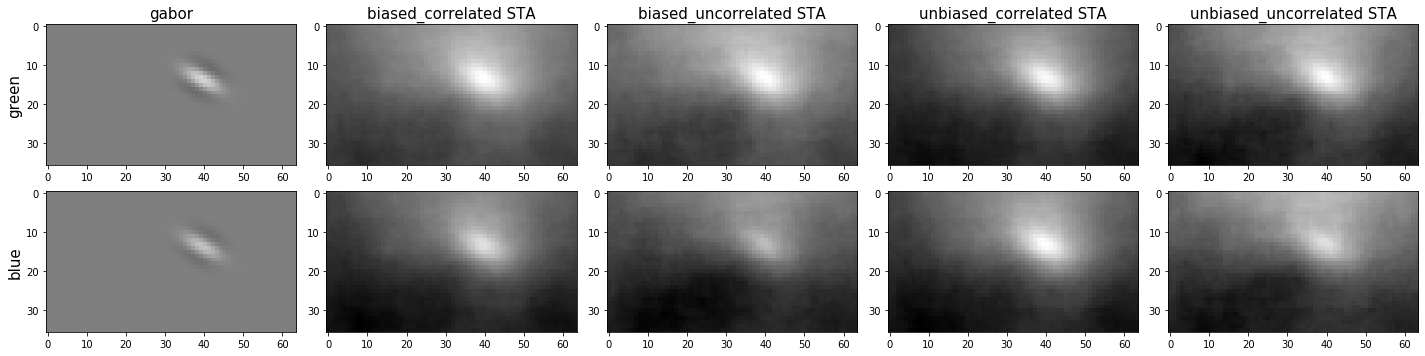

In [22]:
plot_sta(img_dict, int_kernels, 5, 'sta_rf_poisson')

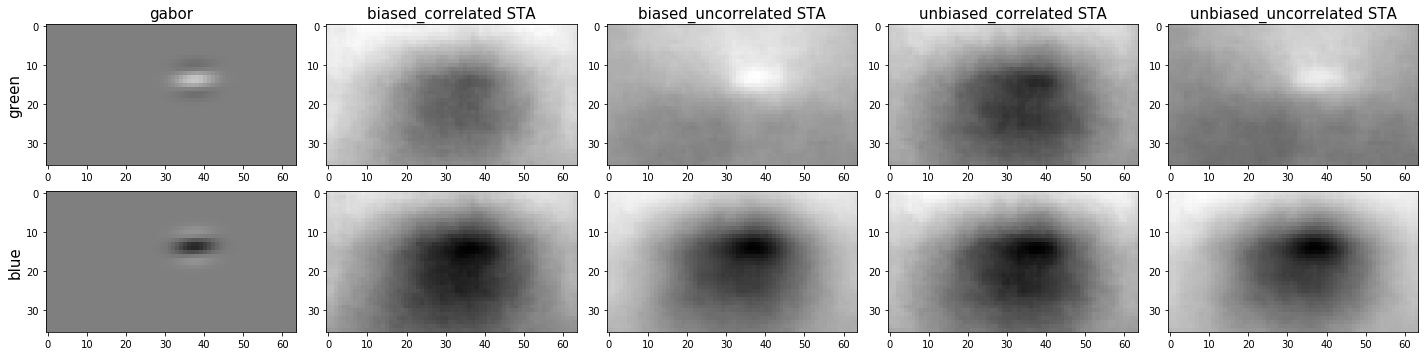

In [23]:
plot_sta(img_dict, int_kernels, 500, 'sta_rf_poisson')

In [80]:
stim_size = 6000
white_noise_stimulus = []
for i in range(stim_size):
    
    noise = []
    for channel in range(2):
        np.random.seed(i*2 +channel)
        noise.append(np.random.normal(0.0,10.0, 36*64).reshape(36,64))
    
    white_noise_stimulus.append(np.stack(noise))
white_noise_stimulus = np.stack(white_noise_stimulus).transpose(0,2,3,1)

In [84]:
def generate_response_block_with_white_noise(orig_kernels, white_noise):
    
    kernels = []
    
    for kernel in orig_kernels:
        # subtract mean from both channels
        kernels.append(kernel - kernel.mean(0).mean(0))
        
    kernels = np.stack(kernels)
    
    response_block = np.zeros((len(white_noise), len(kernels)))
    # multiply images with kernels
    for img_ind, img in enumerate(white_noise):
        
        if not img_ind%100:
            print(img_ind)
        convolved = np.multiply(img, kernels)

        # introduce nonlinearity
#         convolved[convolved<0] = 0 

        signals = convolved.reshape(len(kernels),-1).sum(-1)

        response_block[img_ind,:] = signals
    return response_block

In [85]:
white_noise_response = generate_response_block_with_white_noise(orig_kernels=int_kernels, white_noise=white_noise_stimulus)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900


In [89]:
norm_white_noise_response = np.zeros(white_noise_response.shape)

for ind, response in enumerate(white_noise_response.T):
        norm_white_noise_response[:,ind] = (response - response.min())/(response.max() - response.min()) * 100

In [90]:
poisson_white_noise_response = np.zeros(norm_white_noise_response.shape)

for ind, response in enumerate(norm_white_noise_response.T):
        poisson_white_noise_response[:,ind] = np.random.poisson(response)

In [92]:
white_noise_dict = dict(img = white_noise_stimulus, 
                        response = white_noise_response, 
                        norm_response = norm_white_noise_response,
                        poisson_response = poisson_white_noise_response)

In [93]:
def sta_generation_white_noise(white_noise_dict, percentile=50, response_case = 'norm_response'): 
    
    response_block = white_noise_dict[response_case]

    images = white_noise_dict['img']
    
    #Note when generating STAs, we do not subtract the mean
    
    sta_rf = np.zeros(shape=(response_block.shape[-1],*images.shape[1:]))

    
    for ind, response in enumerate(response_block.T):
        if ind%100 == 0:
            print(ind)
        percentile_val = np.percentile(response, percentile)

        percentile_inds = np.where(response > percentile_val)[0]

        sta_rf[ind] = np.average(images[percentile_inds], 
                                 weights=response[percentile_inds]/response[percentile_inds].sum(), 
                                 axis=0)
    return sta_rf

In [94]:
sta_white_noise = {}
for _case in ['norm_response','poisson_response']:
    sta_white_noise[_case] = sta_generation_white_noise(white_noise_dict, response_case = _case)

0
100
200
300
400
500
600
0
100
200
300
400
500
600


In [95]:
sta_white_noise['poisson_response'].shape

(700, 36, 64, 2)

In [100]:
def plot_sta_white_noise(sta_dict, kernel_num):
    fig, ax = plt.subplots(2,3, figsize=(10,5))
    
    ax[0][0].set_title('gabor', fontsize=15)
    ax[0][0].imshow(int_kernels[kernel_num,:,:,0], cmap='gray', vmin=0, vmax=255)
    ax[0][0].set_ylabel('green', fontsize=15)
    ax[1][0].imshow(int_kernels[kernel_num,:,:,1], cmap='gray', vmin=0, vmax=255)
    ax[1][0].set_ylabel('blue', fontsize=15)
    
    for ind, (key, sta_rf) in enumerate(sta_dict.items()):
        
        vmin_g, vmax_g = sta_rf[kernel_num,:,:,0].min(), sta_rf[kernel_num,:,:,0].max()
        vmin_b, vmax_b = sta_rf[kernel_num,:,:,1].min(), sta_rf[kernel_num,:,:,1].max()

        vmin = min(vmin_g, vmin_b)
        vmax = max(vmax_g, vmax_b)
        
        ax[0][ind+1].set_title(key + ' STA', fontsize=15)
        ax[0][ind+1].imshow(sta_rf[kernel_num,:,:,0], 
                            cmap='gray', 
                            vmin=vmin, 
                            vmax=vmax)
        
        ax[1][ind+1].imshow(sta_rf[kernel_num,:,:,1], 
                            cmap='gray', 
                            vmin=vmin,
                            vmax=vmax)

    plt.tight_layout()

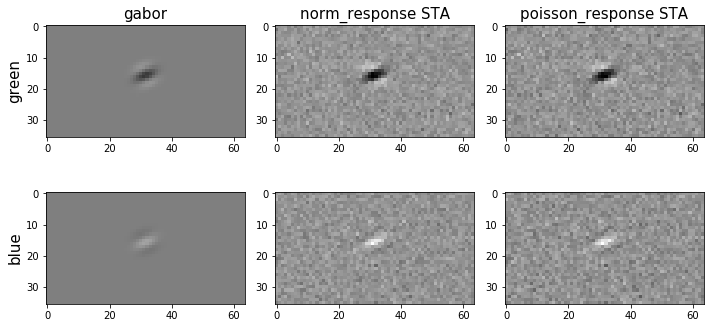

In [101]:
plot_sta_white_noise(sta_white_noise, 0)

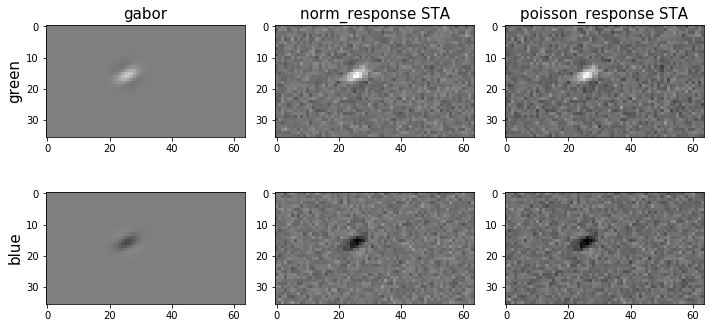

In [102]:
plot_sta_white_noise(sta_white_noise, 100)

In [228]:
kernel_num = 210

unbiased_uncorrelated_response = img_dict['unbiased_uncorrelated']['response_block'][:,kernel_num]
biased_uncorrelated_response = img_dict['biased_uncorrelated']['response_block'][:,kernel_num]

# now obtain stats

In [25]:
for key in img_dict.keys():
    img_dict[key]['df'] = pd.DataFrame.from_dict(obtain_stats(img_dict[key]['sta_rf_poisson']))

In [26]:
for key in img_dict.keys():
    img_dict[key]['input_img_df'] = pd.DataFrame.from_dict(obtain_stats_rgb(img_dict[key]['img']))

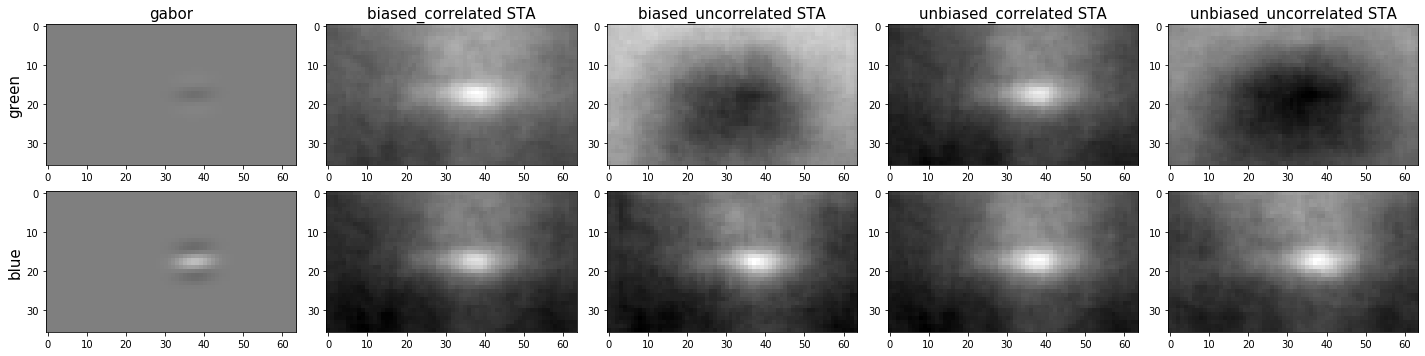

In [47]:
plot_sta(img_dict, biased_kernels, 10, 'sta_rf_poisson')

# Input image plots

biased_correlated
40.745768229166664 216.00401475694446
biased_uncorrelated
40.745768229166664 216.00401475694446
unbiased_correlated
126.54939778645833 127.47501627604167
unbiased_uncorrelated
126.50018988715277 127.47501627604167


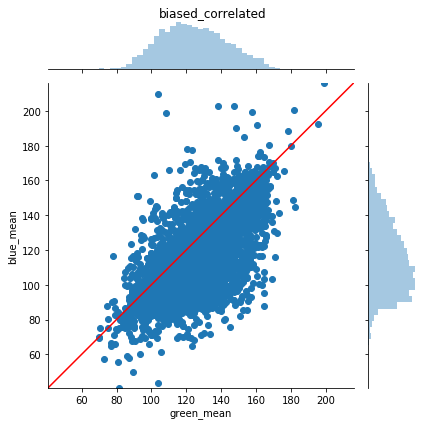

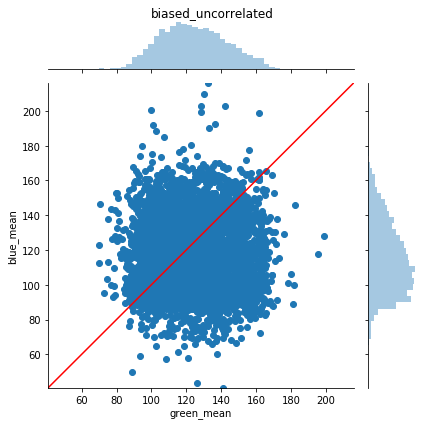

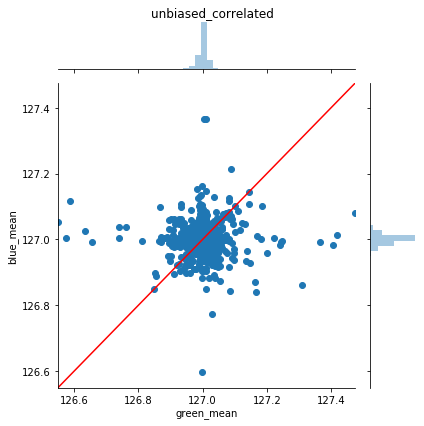

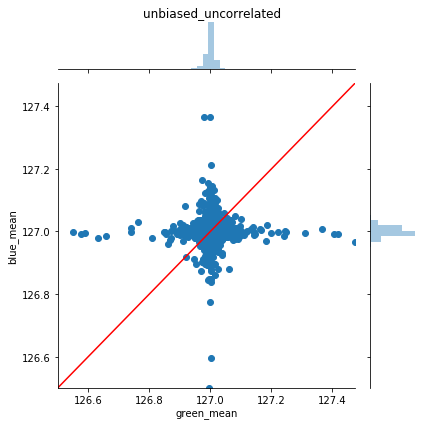

In [27]:
for key in img_dict.keys():
    print(key)
   
    
    x_min = img_dict[key]['input_img_df']['green_mean'].min()
    x_max = img_dict[key]['input_img_df']['green_mean'].max()
    y_min = img_dict[key]['input_img_df']['blue_mean'].min()
    y_max = img_dict[key]['input_img_df']['blue_mean'].max()
    
    _min = min(x_min, y_min)
    _max = max(x_max, y_max)
    
    print(_min,_max)
    
    g = sns.jointplot(x='green_mean', y='blue_mean',data=img_dict[key]['input_img_df'],xlim=(_min,_max),ylim=(_min,_max))
    
    g.x = [_min, _max]
    g.y = [_min, _max]
    
    g.plot_joint(plt.plot, color='r')
    
    # Set title
    g.fig.suptitle(key)

    # Format nicely.
    g.fig.tight_layout()

    # Reduce plot to make room for suptitle
    g.fig.subplots_adjust(top=0.95)

biased_correlated
9.279421687622175 123.50806220119048
biased_uncorrelated
9.279421687622175 123.50806220119048
unbiased_correlated
12.565816594089142 94.4402585394697
unbiased_uncorrelated
12.565816594089142 94.4402585394697


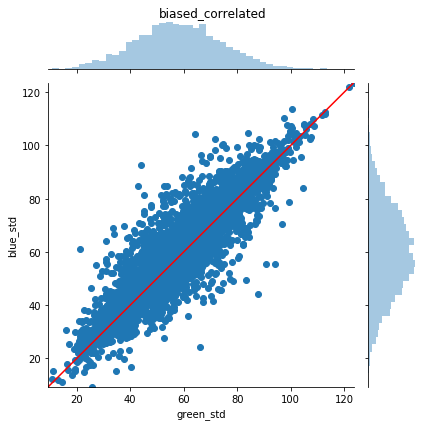

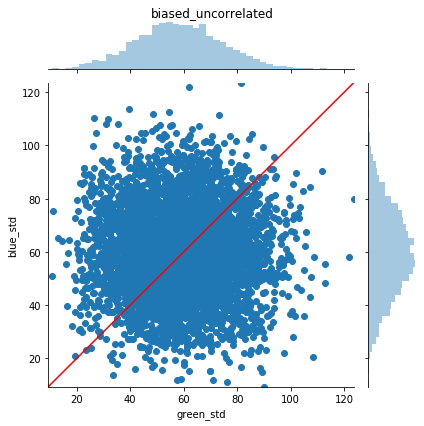

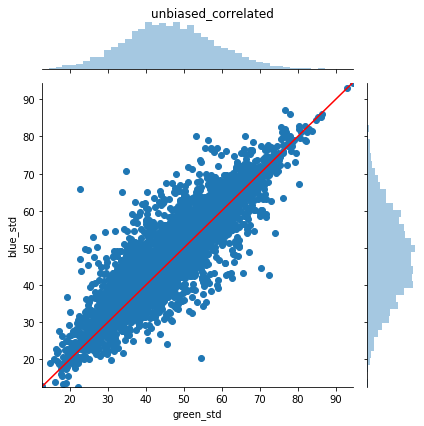

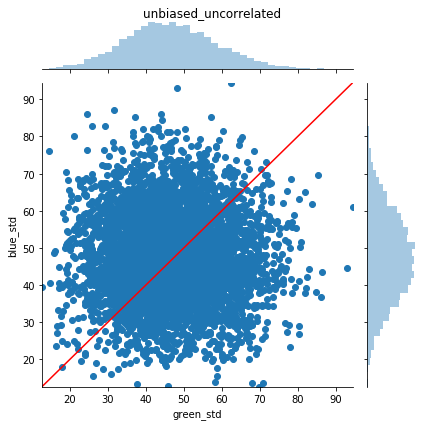

In [28]:
for key in img_dict.keys():
    print(key)
   
    
    x_min = img_dict[key]['input_img_df']['green_std'].min()
    x_max = img_dict[key]['input_img_df']['green_std'].max()
    y_min = img_dict[key]['input_img_df']['blue_std'].min()
    y_max = img_dict[key]['input_img_df']['blue_std'].max()
    
    _min = min(x_min, y_min)
    _max = max(x_max, y_max)
    
    print(_min,_max)
    
    g = sns.jointplot(x='green_std', y='blue_std',data=img_dict[key]['input_img_df'],xlim=(_min,_max),ylim=(_min,_max))
    
    g.x = [_min, _max]
    g.y = [_min, _max]
    
    g.plot_joint(plt.plot, color='r')
    
    # Set title
    g.fig.suptitle(key)

    # Format nicely.
    g.fig.tight_layout()

    # Reduce plot to make room for suptitle
    g.fig.subplots_adjust(top=0.95)

In [33]:
for key in img_dict.keys():
    
    print(key)
    
    for _case in ['mean']:
        green_values = img_dict[key]['input_img_df']['green_'+_case]
        blue_values = img_dict[key]['input_img_df']['blue_'+_case]
        
        _, p_val = pearsonr(green_values, blue_values)
        print('pearson correlation p-val on {0}: {1:.5f}'.format(_case, p_val))
        
        _, p_val = ttest_ind(green_values, blue_values)
        print('student t-test p-val on {0}: {1:.5f}'.format(_case, p_val))

    print('-----------------------')

biased_correlated
pearson correlation p-val on mean: 0.00000
student t-test p-val on mean: 0.00000
-----------------------
biased_uncorrelated
pearson correlation p-val on mean: 0.79111
student t-test p-val on mean: 0.00000
-----------------------
unbiased_correlated
pearson correlation p-val on mean: 0.76395
student t-test p-val on mean: 0.85365
-----------------------
unbiased_uncorrelated
pearson correlation p-val on mean: 0.78030
student t-test p-val on mean: 0.85819
-----------------------


In [32]:
for key in img_dict.keys():
    
    print(key)
    
    for _case in ['std']:
        green_values = img_dict[key]['input_img_df']['green_'+_case]
        blue_values = img_dict[key]['input_img_df']['blue_'+_case]
        
        _, p_val = pearsonr(green_values, blue_values)
        print('pearson correlation p-val on {0}: {1:.5f}'.format(_case, p_val))
        
        _, p_val = ttest_ind(green_values, blue_values)
        print('student t-test p-val on {0}: {1:.5f}'.format(_case, p_val))

    print('-----------------------')

biased_correlated
pearson correlation p-val on std: 0.00000
student t-test p-val on std: 0.00000
-----------------------
biased_uncorrelated
pearson correlation p-val on std: 0.26951
student t-test p-val on std: 0.00000
-----------------------
unbiased_correlated
pearson correlation p-val on std: 0.00000
student t-test p-val on std: 0.00000
-----------------------
unbiased_uncorrelated
pearson correlation p-val on std: 0.62569
student t-test p-val on std: 0.00000
-----------------------


# STAs

113.43171033018038 126.5275565776975
113.48802674879184 126.64264824557101
126.99886111143034 127.00181849960482
126.99888743611513 127.00163872944339


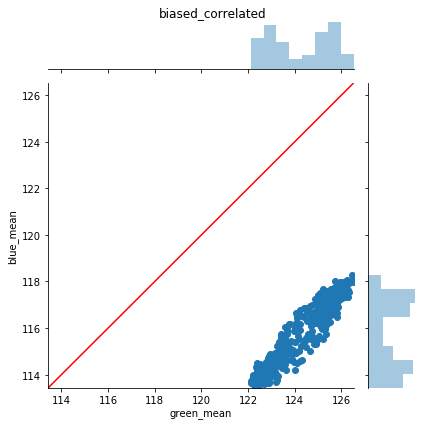

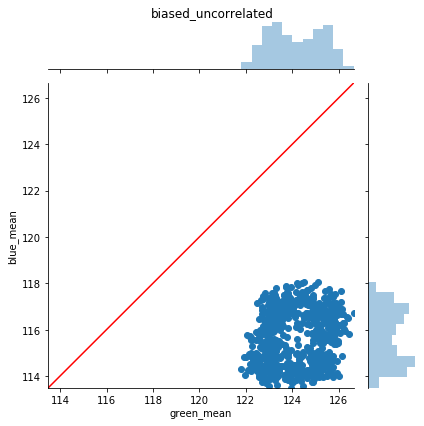

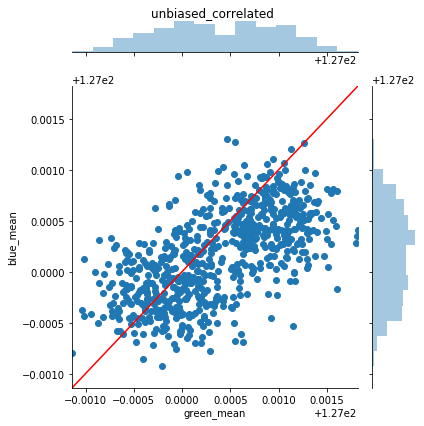

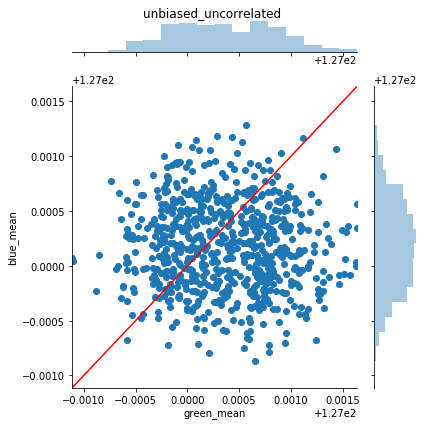

In [34]:
for key in img_dict.keys():
   
    
    x_min = img_dict[key]['df']['green_mean'].min()
    x_max = img_dict[key]['df']['green_mean'].max()
    y_min = img_dict[key]['df']['blue_mean'].min()
    y_max = img_dict[key]['df']['blue_mean'].max()
    
    _min = min(x_min, y_min)
    _max = max(x_max, y_max)
    
    print(_min,_max)
    
    g = sns.jointplot(x='green_mean', y='blue_mean',data=img_dict[key]['df'],xlim=(_min,_max),ylim=(_min,_max))
    
    g.x = [_min, _max]
    g.y = [_min, _max]
    
    g.plot_joint(plt.plot, color='r')
    
    # Set title
    g.fig.suptitle(key)

    # Format nicely.
    g.fig.tight_layout()

    # Reduce plot to make room for suptitle
    g.fig.subplots_adjust(top=0.95)

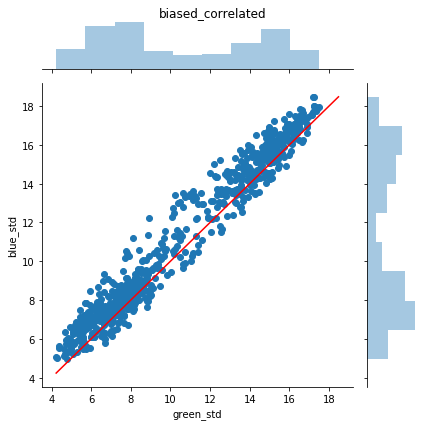

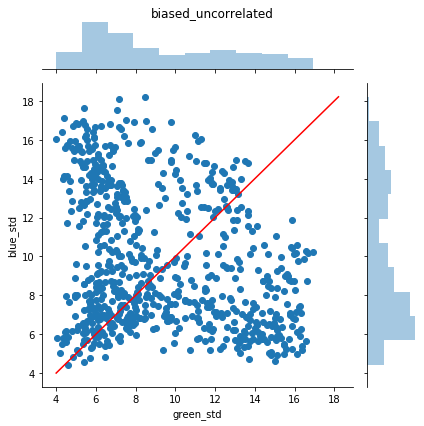

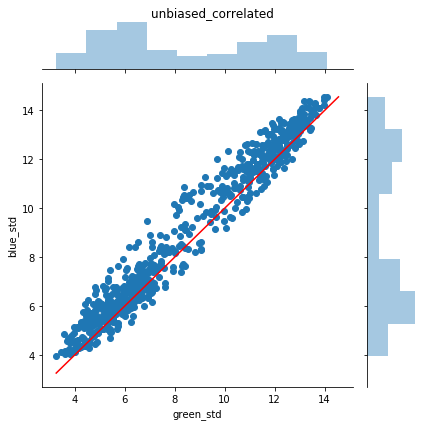

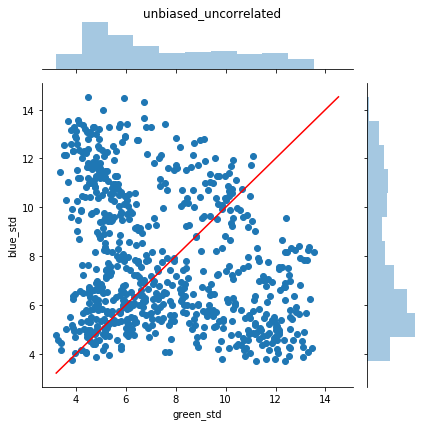

In [35]:
for key in img_dict.keys():
    g = sns.jointplot(x='green_std', y='blue_std',data=img_dict[key]['df'])
    
    x_min = img_dict[key]['df']['green_std'].min()
    x_max = img_dict[key]['df']['green_std'].max()
    y_min = img_dict[key]['df']['blue_std'].min()
    y_max = img_dict[key]['df']['blue_std'].max()
    
    _min = min(x_min, y_min)
    _max = max(x_max, y_max)
    
    g.x = [_min, _max]
    g.y = [_min, _max]
    
    g.plot_joint(plt.plot, color='r')
    
    # Set title
    g.fig.suptitle(key)

    # Format nicely.
    g.fig.tight_layout()

    # Reduce plot to make room for suptitle
    g.fig.subplots_adjust(top=0.95)

In [65]:
kernel_df = pd.DataFrame.from_dict(obtain_stats(int_kernels))

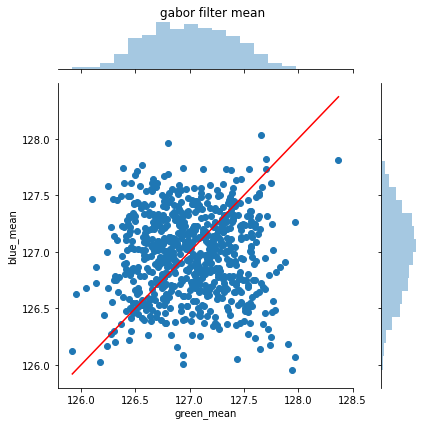

In [66]:
g = sns.jointplot(x='green_mean', y='blue_mean',data=kernel_df)
    
x_min = kernel_df['green_mean'].min()
x_max = kernel_df['green_mean'].max()
y_min = kernel_df['blue_mean'].min()
y_max = kernel_df['blue_mean'].max()

_min = min(x_min, y_min)
_max = max(x_max, y_max)

g.x = [_min, _max]
g.y = [_min, _max]

g.plot_joint(plt.plot, color='r')

# Set title
g.fig.suptitle('gabor filter mean')

# Format nicely.
g.fig.tight_layout()

# Reduce plot to make room for suptitle
g.fig.subplots_adjust(top=0.95)

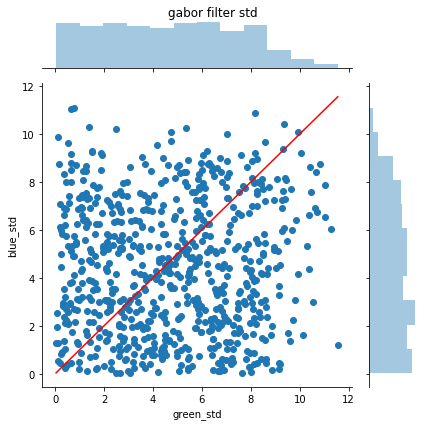

In [67]:
g = sns.jointplot(x='green_std', y='blue_std',data=kernel_df)
    
x_min = kernel_df['green_std'].min()
x_max = kernel_df['green_std'].max()
y_min = kernel_df['blue_std'].min()
y_max = kernel_df['blue_std'].max()

_min = min(x_min, y_min)
_max = max(x_max, y_max)

g.x = [_min, _max]
g.y = [_min, _max]

g.plot_joint(plt.plot, color='r')

# Set title
g.fig.suptitle('gabor filter std')

# Format nicely.
g.fig.tight_layout()

# Reduce plot to make room for suptitle
g.fig.subplots_adjust(top=0.95)

In [68]:
for key in img_dict.keys():
    
    print(key)
    
    for _case in ['mean']:
        green_values = img_dict[key]['df']['green_'+_case]
        blue_values = img_dict[key]['df']['blue_'+_case]
        
        _, p_val = pearsonr(green_values, blue_values)
        print('pearson correlation p-val on {0}: {1:.5f}'.format(_case, p_val))
        
        _, p_val = ttest_ind(green_values, blue_values)
        print('student t-test p-val on {0}: {1:.5f}'.format(_case, p_val))

    print('-----------------------')

biased_correlated
pearson correlation p-val on mean: 0.00000
student t-test p-val on mean: 0.00000
-----------------------
biased_uncorrelated
pearson correlation p-val on mean: 0.00480
student t-test p-val on mean: 0.00000
-----------------------
unbiased_correlated
pearson correlation p-val on mean: 0.00000
student t-test p-val on mean: 0.00000
-----------------------
unbiased_uncorrelated
pearson correlation p-val on mean: 0.12220
student t-test p-val on mean: 0.00000
-----------------------


In [40]:
for key in img_dict.keys():
    
    print(key)
    
    for _case in ['std']:
        green_values = img_dict[key]['df']['green_'+_case]
        blue_values = img_dict[key]['df']['blue_'+_case]
        
        _, p_val = pearsonr(green_values, blue_values)
        print('pearson correlation p-val on {0}: {1:.5f}'.format(_case, p_val))
        
        _, p_val = ttest_ind(green_values, blue_values)
        print('student t-test p-val on {0}: {1:.5f}'.format(_case, p_val))

    print('-----------------------')

biased_correlated
pearson correlation p-val on std: 0.00000
student t-test p-val on std: 0.00182
-----------------------
biased_uncorrelated
pearson correlation p-val on std: 0.00000
student t-test p-val on std: 0.00482
-----------------------
unbiased_correlated
pearson correlation p-val on std: 0.00000
student t-test p-val on std: 0.00304
-----------------------
unbiased_uncorrelated
pearson correlation p-val on std: 0.00000
student t-test p-val on std: 0.02478
-----------------------


# difference plot

difference in mean and sd across input channels (gabor filters) vs the difference in mean and sd of the sta channels

In [79]:
def obtain_stats_gabor(images, outliers=[]):
    stats = dict(blue_mean =[], green_mean= [], blue_std=[], green_std=[], blue_range=[], green_range=[])
    
    for ind, img in enumerate(images):
        if ind in outliers:
            # outlier detected, pass
            continue
        stats['green_mean'].append(img[:,:,0].mean())
        stats['blue_mean'].append(img[:,:,1].mean())

        stats['green_std'].append(img[:,:,0].std())
        stats['blue_std'].append(img[:,:,1].std())
        
        stats['green_range'].append(img[:,:,0].max()-img[:,:,0].min())
        stats['blue_range'].append(img[:,:,1].max()-img[:,:,1].min())
    
    return stats

In [80]:
kernel_df = pd.DataFrame.from_dict(obtain_stats_gabor(int_kernels))

In [83]:
gabor_mean_diff = kernel_df['green_mean'] - kernel_df['blue_mean']
gabor_std_diff = kernel_df['green_std'] - kernel_df['blue_std']
gabor_range_diff = kernel_df['green_range'] - kernel_df['blue_range']

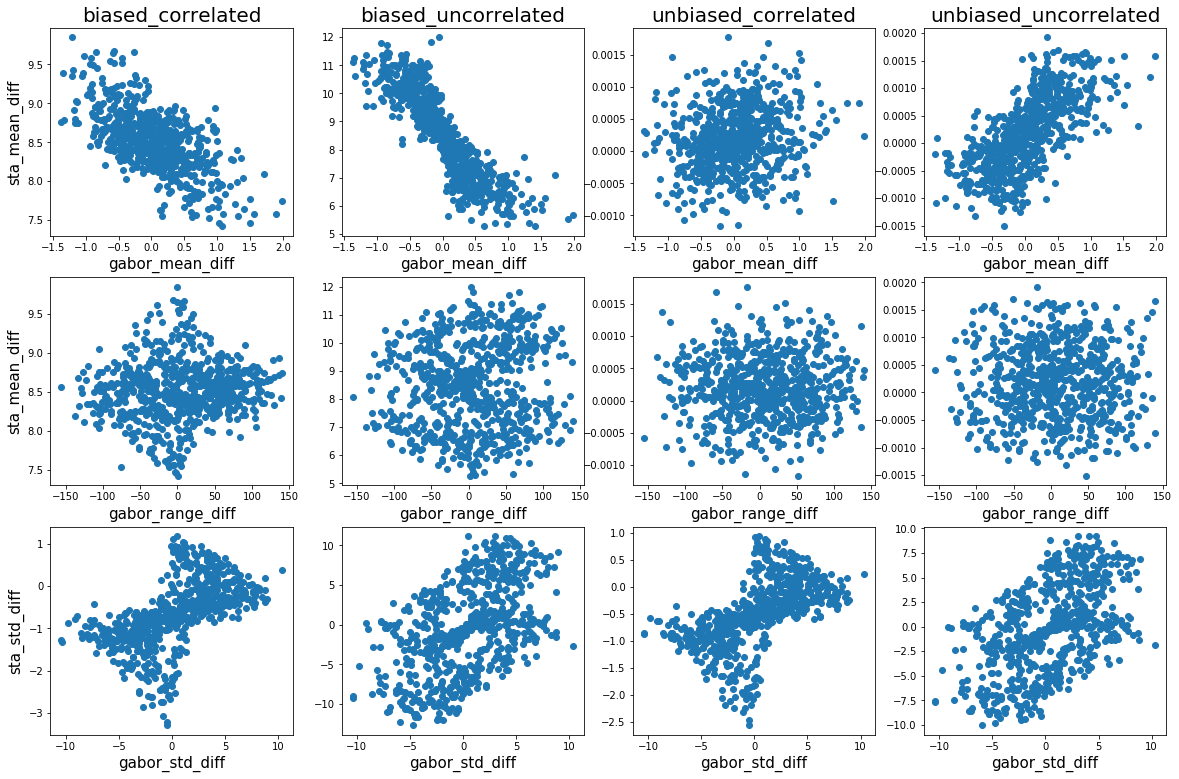

In [105]:
fig, ax = plt.subplots(3,4, figsize=(20,13))

for ind, (key, ax_col) in enumerate(zip(img_dict.keys(), ax.T)):
    
    if ind ==0:
        ax_col[0].set_ylabel('sta_mean_diff', fontsize=15)
        ax_col[1].set_ylabel('sta_mean_diff', fontsize=15)
        ax_col[2].set_ylabel('sta_std_diff', fontsize=15)
    # plot mean
    sta_mean_diff = img_dict[key]['df']['green_mean'] - img_dict[key]['df']['blue_mean']
    ax_col[0].plot(gabor_mean_diff, sta_mean_diff, 'o')
    ax_col[0].set_xlabel('gabor_mean_diff', fontsize=15)
    ax_col[0].set_title(key, fontsize=20)
    
    #plot gabor range vs sta mean
    ax_col[1].plot(gabor_range_diff, sta_mean_diff, 'o')
    ax_col[1].set_xlabel('gabor_range_diff', fontsize=15)

    #plot std
    sta_std_diff = img_dict[key]['df']['green_std'] - img_dict[key]['df']['blue_std']
    ax_col[2].plot(gabor_std_diff, sta_std_diff, 'o')    
    ax_col[2].set_xlabel('gabor_std_diff', fontsize=15)

    


# Correlation between channels plot

In [108]:
int_kernels.shape

(700, 36, 64, 2)

In [112]:
kernel_correlation_btw_2_channels = []
for kernel in int_kernels:
    kernel_correlation_btw_2_channels.append(pearsonr(kernel[:,:,0].flatten(),kernel[:,:,1].flatten())[0])


In [117]:
kernel_correlation_btw_2_channels

[-0.9999999999998257,
 -0.9999999999999282,
 -0.9999999999998894,
 -0.9999999999997016,
 -0.9999999998029853,
 0.9999999999999287,
 0.999999999998541,
 0.9999999999994775,
 -0.9999999999997606,
 0.9999999999971882,
 0.9999999999988003,
 -0.9999999999999166,
 0.9999999999942392,
 0.9999999999999539,
 0.9999999999998822,
 -0.9999999999936752,
 -0.9999999999997686,
 -0.9999999999997997,
 -0.9999999999994924,
 0.9999999999998903,
 0.9999999999996266,
 -0.9999999999934874,
 0.9999999999988308,
 0.9999999999970786,
 0.999999999984298,
 0.9999999999999417,
 -0.999999999999949,
 0.9999999999999372,
 0.9999999999935741,
 0.999999999945026,
 -0.9999999999998156,
 -0.9999999999945954,
 0.9999999999996863,
 -0.9999999999991849,
 -0.9999999999973482,
 0.9999999999998808,
 -0.9999999999989686,
 0.9999999999662674,
 0.9999999999996945,
 -0.9999999999997305,
 0.9999999999999538,
 0.9999999999997223,
 0.9999999999999214,
 -0.9999999999999486,
 -0.9999999999997653,
 -0.9999999999999488,
 -0.999999999999

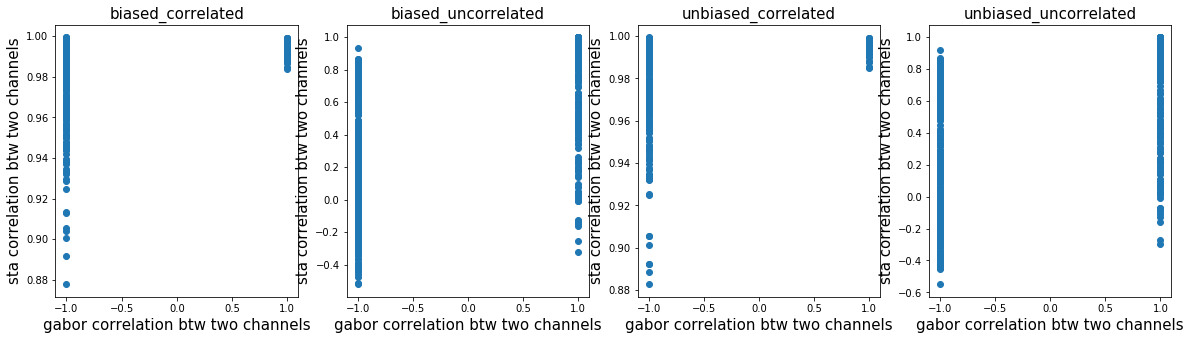

In [119]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for key, _ax in zip(img_dict.keys(), ax):
    sta_correlation_btw_2_channels = []
    stas = img_dict[key]['sta_rf_poisson']
    
    for img in stas:
        sta_correlation_btw_2_channels.append(pearsonr(img[:,:,0].flatten(),img[:,:,1].flatten())[0])
    
    _ax.plot(kernel_correlation_btw_2_channels, sta_correlation_btw_2_channels,'o')
    _ax.set_title(key, fontsize=15)
    _ax.set_xlabel('gabor correlation btw two channels', fontsize=15)
    _ax.set_ylabel('sta correlation btw two channels', fontsize=15)
    

In [107]:
img_dict[key]['sta_rf_poisson'].shape

(700, 36, 64, 2)

# PLOTTING STATS AND WHATNOT

In [37]:
# image stats
# first preprocess original images such that it matches to the format that MEI model takes
for key in img_dict.keys():

    img_tmp = []
    images = img_dict[key]['img']

    for img_ind, img in enumerate(images):
        img = cv2.resize(img, (64,36), interpolation=cv2.INTER_AREA).astype(np.float32)[:,:,1:]
        img_tmp.append(img)
    
    img_dict[key]['img_mei_fit'] = np.stack(img_tmp)
    

In [44]:
for key in img_dict.keys():
    
    df = pd.DataFrame.from_dict(obtain_stats(img_dict[key]['img_mei_fit']))
    
    g = sns.jointplot(x='green_mean', y='blue_mean', x = df)
    
    sns.jointplot(x='green_std', y='blue_std', x = df)

array([ 94., 127.], dtype=float32)

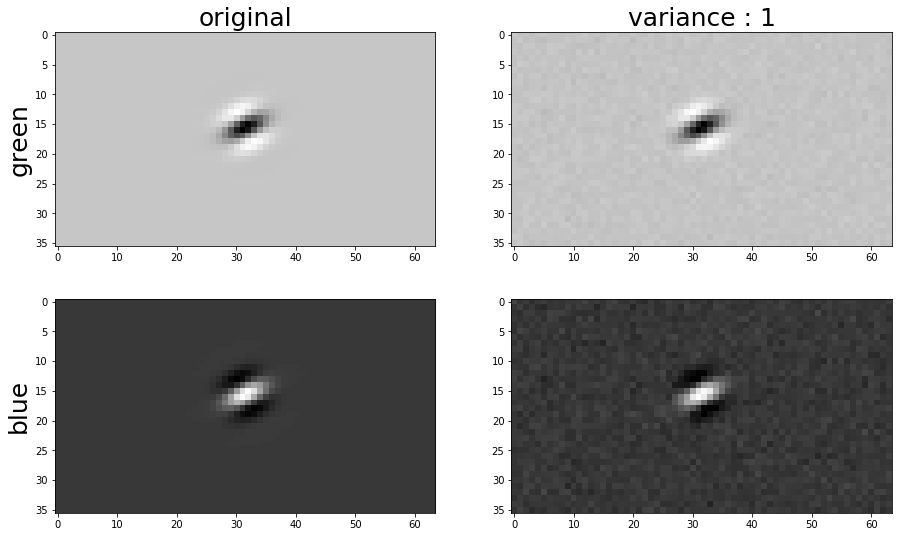

In [36]:
sample = int_kernels[0]
fig, ax = plt.subplots(2,2, figsize=(15,9))

ax[0,0].imshow(sample[:,:,0], cmap='gray')
ax[0,0].set_ylabel('green', fontsize=25)

ax[0,0].set_title('original', fontsize=25)
ax[1,0].imshow(sample[:,:,1], cmap='gray')
ax[1,0].set_ylabel('blue', fontsize=25)

for ind, var in enumerate([1]):
    
    
    mean = 127

    row, col, ch = sample.shape
    sigma = var**0.5
    gauss_noise = np.random.normal(mean, sigma, (row,col,1))
    gauss_noise = np.repeat(gauss_noise, ch, axis=2)

    noisy_kernel = sample + gauss_noise
    
    ax[0, ind+1].imshow(noisy_kernel[:,:,0], cmap='gray')
    ax[0, ind+1].set_title('variance : {}'.format(var), fontsize=25)
    ax[1, ind+1].imshow(noisy_kernel[:,:,1], cmap='gray')

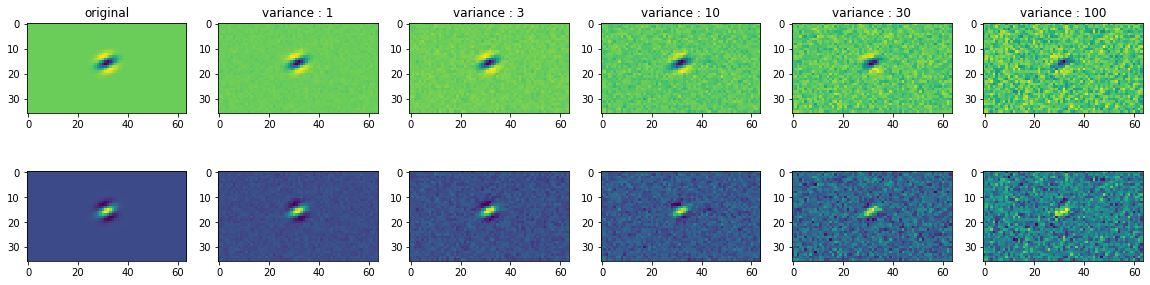

In [9]:
sample = int_kernels[0]
fig, ax = plt.subplots(2,6, figsize=(20,5))

ax[0,0].imshow(sample[:,:,0])
ax[0,0].set_title('original')
ax[1,0].imshow(sample[:,:,1])

for ind, var in enumerate([1,3,10,30,100]):
    
    
    mean = 127

    row, col, ch = sample.shape
    sigma = var**0.5
    gauss_noise = np.random.normal(mean, sigma, (row,col,1))
    gauss_noise = np.repeat(gauss_noise, ch, axis=2)

    noisy_kernel = sample + gauss_noise
    
    ax[0, ind+1].imshow(noisy_kernel[:,:,0])
    ax[0, ind+1].set_title('variance : {}'.format(var))
    ax[1, ind+1].imshow(noisy_kernel[:,:,1])